In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from torch.utils.data import Dataset, DataLoader
from torchcrf import CRF
from deeppavlov.models.embedders.fasttext_embedder import FasttextEmbedder
import re
import json
import nltk
nltk.download("punkt")
from nltk import sent_tokenize, word_tokenize
from nltk.tokenize.util import align_tokens
from glob import glob
from functools import partial
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook as tqdm
from conlleval import evaluate as prec_rec_f
from brat_format import read_file, BratDoc
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

[nltk_data] Downloading package punkt to /home/dmitry/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
def span_sentences(text, shift=0):
    sents = sent_tokenize(text, language="russian")
    spans = align_tokens(sents, text)
    spans = [(start + shift, end + shift) for start, end in spans]
    
    return sents, spans


def span_tokens(text, shift=0):
    tokens, spans = [], []

    for tok in re.finditer(r"([^\W_]+|\S)", text):
        tokens.append(tok.group(1))
        spans.append((shift + tok.start(1), 
                      shift + tok.end(1)))
    
    return tokens, spans


def to_conll(brat_ners, spans):
    conll_ners = []

    for token_start, token_end in spans:
        
        for ner in brat_ners:
            
            if (ner["start"] <= token_start) and (ner["end"] >= token_end):
                prefix = "I" if (ner["start"] < token_start) else "B"
                conll_ners.append(prefix + "-" + ner["ner_type"])
                break
        
        else:
            conll_ners.append("O")  
    
    return conll_ners


def to_brat(conll_ners, spans, ner_id=1):
    brat_ners = []
    prev = "O"

    for tag, (token_start, token_end)  in zip(conll_ners, spans):
        splitted_tag = tag.split("-")
        
        if len(splitted_tag) > 1:
            prefix, ner_type = splitted_tag
            
            if prefix == "I":
                
                if prev != "O":
                    brat_ners[-1]["end"] = token_end
                    prev = "I"
                    continue
            
            brat_ners.append({"ner_id": ner_id, 
                              "ner_type": ner_type, 
                              "start": token_start, 
                              "end": token_end})
            prev = "B"
            ner_id += 1
        
        else:
            prev = "O"

    return brat_ners


def extract_data(files):
    tokens, tags = [], []

    for file_path in tqdm(files):
        brat_doc = read_file(file_path)
        doc_ners = [{"id": i, 
                    "ner_type": brat_doc.ners[idx][0], 
                    "start": brat_doc.ners[idx][1], 
                    "end": brat_doc.ners[idx][2]} 
                    for i, idx in brat_doc.ner_id_2_idx.items()]
        
        for line in re.finditer(r"[^\n]+(\n+|$)", brat_doc.txt_data):
            sents, sent_spans = span_sentences(line.group(0), shift=line.start())
            
            for sent, (sent_start, _) in zip(sents, sent_spans):
                toks, spans = span_tokens(sent, shift=sent_start)
                tokens.append(toks)
                tags.append(to_conll(doc_ners, spans))

    return tokens, tags

In [3]:
files = glob("data/train/*.ann")
tokens, tags = extract_data(files)

/tmp/ipykernel_16184/2447471701.py:71: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for file_path in tqdm(files):


  0%|          | 0/188 [00:00<?, ?it/s]

In [18]:
tokens[:10], tags[:10]

([['ГОСУДАРСТВЕННАЯ', 'ПРОГРАММА'],
  ['РЕСПУБЛИКИ', 'КОМИ', '"', 'ЮСТИЦИЯ', 'И', 'ОБЕСПЕЧЕНИЕ'],
  ['ПРАВОПОРЯДКА', 'В', 'РЕСПУБЛИКЕ', 'КОМИ', '"'],
  ['ПАСПОРТ'],
  ['Государственной', 'программы', 'Республики', 'Коми', '"', 'Юстиция'],
  ['и', 'обеспечение', 'правопорядка', 'в', 'Республике', 'Коми', '"'],
  ['(', 'далее', '-', 'Программа', ')'],
  ['Паспорт', 'подпрограммы'],
  ['"', 'Правовая', 'защищенность', 'населения', 'Республики', 'Коми', '"'],
  ['(', 'далее', '-', 'Подпрограмма', '1', ')']],
 ['I-SOC',
  'B-MET',
  'I-ECO',
  'I-CMP',
  'B-ECO',
  'I-QUA',
  'I-MET',
  'B-BIN',
  'B-CMP',
  'O'])

In [8]:
train_tokens, val_tokens, train_tags, val_tags = train_test_split(tokens, tags, 
                                                                  test_size=0.1)
len(train_tokens), len(val_tokens)

(19026, 2115)

In [9]:
class NER_Dataset(Dataset):
    def __init__(self, tag2id, seqs, seq_tags):
        self.tag2id = tag2id
        self.seqs = [[token.lower() for token in seq] for seq in seqs]
        self.seq_tags = [[self.tag2id[tag] for tag in tags] for tags in seq_tags]

    def __len__(self):
        return len(self.seqs)

    def __getitem__(self, idx):
        return self.seqs[idx], self.seq_tags[idx]

In [10]:
tags = list({tag for sent in train_tags for tag in sent})
tag2id = {tag: i for i, tag in enumerate(tags)}
id2tag = {i: tag for i, tag in enumerate(tags)}

with open("tags.json", "w") as f:
    json.dump(tags, f)

tags

['I-SOC',
 'B-MET',
 'I-ECO',
 'I-CMP',
 'B-ECO',
 'I-QUA',
 'I-MET',
 'B-BIN',
 'B-CMP',
 'O',
 'B-QUA',
 'I-INST',
 'B-ACT',
 'B-SOC',
 'I-ACT',
 'I-BIN',
 'B-INST']

In [21]:
train_ds = NER_Dataset(tag2id, train_tokens, train_tags)
val_ds = NER_Dataset(tag2id, val_tokens, val_tags)
len(train_ds), len(val_ds)

(19026, 2115)

In [22]:
val_ds[:2]

([['1', '.'],
  ['формирование',
   'реестра',
   'и',
   'размещение',
   'его',
   'на',
   'официальных',
   'сайтах',
   'органов',
   'исполнительной',
   'власти',
   'края',
   'повысит',
   'информированность',
   'потребителей',
   'композитов',
   '.']],
 [[9, 9], [7, 9, 9, 12, 9, 9, 9, 9, 16, 11, 11, 9, 8, 4, 2, 2, 9]])

In [10]:
class BiLSTM_CRF(nn.Module):
    def __init__(self, embedding_size, hidden_size, feature_dim, num_classes, 
                 dropout):
        super().__init__()
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.feature_dim = feature_dim
        self.num_classes = num_classes
        self.dropout = dropout

        self.lstm = nn.LSTM(embedding_size, hidden_size, 2, bidirectional=True, 
                            batch_first=True)
        self.drop = nn.Dropout(dropout)
        self.fc_0 = nn.Linear(2 * hidden_size, feature_dim)
        self.Q = nn.Linear(feature_dim, feature_dim)
        self.K = nn.Linear(feature_dim, feature_dim)
        self.V = nn.Linear(feature_dim, feature_dim)
        self.layer_norm = nn.LayerNorm(feature_dim)
        self.fc_1 = nn.Linear(feature_dim, num_classes)
        self.crf = CRF(num_classes, batch_first=True)


    def forward(self, x, lengths):
        # LSTM
        x_packed = pack_padded_sequence(x, lengths, batch_first=True)
        seq_out_packed, _ = self.lstm(x_packed)
        seq_out, _ = pad_packed_sequence(seq_out_packed, batch_first=True)
        seq_out = self.drop(seq_out)
        seq_out = self.fc_0(F.relu(seq_out))

        # Attention
        Q, K, V = self.Q(seq_out), self.K(seq_out), self.V(seq_out)
        attn = torch.bmm(Q, K.transpose(1, 2))
        attn /= torch.sqrt(torch.tensor(self.feature_dim, dtype=torch.float))
        attn = F.softmax(attn, dim=-1)
        out = torch.bmm(attn, V)
        out = self.layer_norm(out)

        scores = self.fc_1(out)

        return scores

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
fasttext_embedder = FasttextEmbedder('ft_native_300_ru_wiki_lenta_lemmatize.bin')

In [23]:
def collate_fn(batch):
    x, y = list(zip(*batch))
    
    lengths = torch.tensor(list(map(len, y)))
    lengths, indices = lengths.sort(0, descending=True)

    y = pad_sequence(list(map(torch.tensor, y)), padding_value=-1, batch_first=True)
    y = y[indices]
    mask = (y != -1)
    x = pad_sequence(list(map(torch.tensor, fasttext_embedder(x))), batch_first=True)
    x = x[indices]
    
    return x.to(device), lengths, mask.to(device), y.to(device)

In [24]:
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_ds, batch_size=64, collate_fn=collate_fn)

In [16]:
def train(loader, model, optimizer):
    model.train()
    total_loss = 0
    
    for x, lengths, mask, y in tqdm(loader):
        scores = model(x, lengths)
        loss = -model.crf(scores, y, mask)
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print("Train loss {:.4f}".format(total_loss / len(loader)))
    return total_loss / len(loader) 

def evaluate(loader, model):
    model.eval()
    total_loss = 0
    pred_tags, tags = [], []

    with torch.no_grad():
        
        for x, lengths, mask, y in tqdm(loader):
            scores = model(x, lengths)
            loss = -model.crf(scores, y, mask)
            total_loss += loss.item()

            y_pred = model.crf.decode(scores, mask)
            pred_tags.extend([id2tag[i] for sent in y_pred for i in sent])
            tags.extend([id2tag[i] for i in y[mask].tolist()])

    print("Loss {:.4f}".format(total_loss / len(loader)))
    res = prec_rec_f(tags, pred_tags, verbose=False)
    print("Precision = {:.2f}%, Recall = {:.2f}%, F-score = {:.2f}%".format(*res))
    return total_loss / len(loader), res[-1]

In [17]:
fasttext_embedder.dim

300

In [18]:
from collections import defaultdict

model_params = {"embedding_size": fasttext_embedder.dim, 
                "hidden_size": 200,  
                "feature_dim": 50, 
                "num_classes": len(tag2id), 
                "dropout": 0.2}

model = BiLSTM_CRF(**model_params)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2 * 1e-4)
best_res = -1


losses = defaultdict(list)
val_metrics = defaultdict(list)

for e in range(1000):
    print(f"Epoch {e}")
    train_loss = train(train_loader, model, optimizer)
    losses['Train'].append(train_loss)
    
    val_loss, f_score = evaluate(val_loader, model)
    losses['Val'].append(val_loss)
    val_metrics['F_score'].append(f_score)
    
    if f_score > best_res:
        best_res = f_score
        torch.save(model.state_dict(), "model.pt")
    
    print()

Epoch 0


/tmp/ipykernel_17163/1607356963.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for x, lengths, mask, y in tqdm(loader):


  0%|          | 0/298 [00:00<?, ?it/s]

/tmp/ipykernel_17163/3153277086.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  x = pad_sequence(list(map(torch.tensor, fasttext_embedder(x))), batch_first=True)


Train loss 1850.3153


/tmp/ipykernel_17163/1607356963.py:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for x, lengths, mask, y in tqdm(loader):


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 1597.3171
Precision = 0.00%, Recall = 0.00%, F-score = 0.00%

Epoch 1


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 1640.4454


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 1501.1431
Precision = 0.00%, Recall = 0.00%, F-score = 0.00%

Epoch 2


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 1535.9435


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 1348.8914
Precision = 3.90%, Recall = 0.11%, F-score = 0.21%

Epoch 3


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 1349.3154


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 1216.2031
Precision = 7.87%, Recall = 1.90%, F-score = 3.06%

Epoch 4


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 1200.1548


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 1056.4963
Precision = 20.28%, Recall = 11.20%, F-score = 14.43%

Epoch 5


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 1025.7029


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 902.9320
Precision = 34.67%, Recall = 26.83%, F-score = 30.25%

Epoch 6


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 915.6263


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 836.7457
Precision = 37.74%, Recall = 29.20%, F-score = 32.93%

Epoch 7


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 847.0127


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 786.5796
Precision = 40.41%, Recall = 29.95%, F-score = 34.40%

Epoch 8


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 788.9822


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 747.2763
Precision = 41.02%, Recall = 30.85%, F-score = 35.21%

Epoch 9


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 741.8275


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 707.1964
Precision = 42.91%, Recall = 32.79%, F-score = 37.17%

Epoch 10


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 697.4152


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 662.2171
Precision = 43.74%, Recall = 35.60%, F-score = 39.25%

Epoch 11


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 654.9334


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 645.8722
Precision = 44.47%, Recall = 36.55%, F-score = 40.12%

Epoch 12


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 618.4788


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 613.6932
Precision = 46.51%, Recall = 39.36%, F-score = 42.64%

Epoch 13


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 586.0515


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 603.8970
Precision = 47.50%, Recall = 37.50%, F-score = 41.91%

Epoch 14


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 556.2176


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 564.5369
Precision = 48.97%, Recall = 42.42%, F-score = 45.46%

Epoch 15


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 527.1911


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 562.2677
Precision = 49.73%, Recall = 39.16%, F-score = 43.82%

Epoch 16


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 500.0441


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 553.4398
Precision = 49.08%, Recall = 44.81%, F-score = 46.85%

Epoch 17


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 476.8821


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 526.9112
Precision = 50.31%, Recall = 44.81%, F-score = 47.40%

Epoch 18


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 453.2549


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 525.4150
Precision = 52.34%, Recall = 43.04%, F-score = 47.24%

Epoch 19


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 431.1806


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 506.0698
Precision = 52.51%, Recall = 42.84%, F-score = 47.18%

Epoch 20


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 411.0638


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 514.8684
Precision = 50.72%, Recall = 41.23%, F-score = 45.48%

Epoch 21


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 392.1199


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 503.3336
Precision = 52.21%, Recall = 45.07%, F-score = 48.38%

Epoch 22


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 371.7550


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 508.8668
Precision = 50.18%, Recall = 43.75%, F-score = 46.74%

Epoch 23


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 355.3095


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 489.6177
Precision = 53.88%, Recall = 44.43%, F-score = 48.70%

Epoch 24


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 337.6071


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 486.4703
Precision = 51.32%, Recall = 49.74%, F-score = 50.52%

Epoch 25


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 321.0824


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 490.8151
Precision = 52.51%, Recall = 48.06%, F-score = 50.19%

Epoch 26


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 306.8949


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 482.7449
Precision = 54.85%, Recall = 48.46%, F-score = 51.46%

Epoch 27


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 291.8404


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 480.1099
Precision = 53.53%, Recall = 48.39%, F-score = 50.83%

Epoch 28


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 278.8286


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 492.9152
Precision = 55.06%, Recall = 46.91%, F-score = 50.66%

Epoch 29


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 265.8970


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 482.0440
Precision = 55.07%, Recall = 47.57%, F-score = 51.04%

Epoch 30


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 252.9273


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 485.5958
Precision = 53.82%, Recall = 50.95%, F-score = 52.35%

Epoch 31


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 241.2354


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 498.3487
Precision = 53.19%, Recall = 48.19%, F-score = 50.57%

Epoch 32


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 230.7409


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 511.3100
Precision = 53.81%, Recall = 45.94%, F-score = 49.57%

Epoch 33


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 219.0074


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 515.5278
Precision = 55.18%, Recall = 48.92%, F-score = 51.86%

Epoch 34


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 208.7945


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 505.5095
Precision = 55.70%, Recall = 49.56%, F-score = 52.45%

Epoch 35


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 196.4698


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 507.5756
Precision = 53.99%, Recall = 50.29%, F-score = 52.08%

Epoch 36


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 189.2718


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 522.5193
Precision = 54.54%, Recall = 50.93%, F-score = 52.67%

Epoch 37


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 181.3285


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 520.6718
Precision = 54.44%, Recall = 50.91%, F-score = 52.62%

Epoch 38


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 174.0161


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 519.7909
Precision = 55.02%, Recall = 49.09%, F-score = 51.88%

Epoch 39


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 165.2583


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 535.3821
Precision = 56.14%, Recall = 49.87%, F-score = 52.82%

Epoch 40


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 159.1417


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 544.9772
Precision = 54.32%, Recall = 50.29%, F-score = 52.23%

Epoch 41


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 152.6604


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 549.7282
Precision = 56.05%, Recall = 49.42%, F-score = 52.53%

Epoch 42


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 145.0653


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 571.0997
Precision = 54.80%, Recall = 50.51%, F-score = 52.57%

Epoch 43


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 137.5484


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 579.3615
Precision = 54.01%, Recall = 53.07%, F-score = 53.53%

Epoch 44


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 132.7472


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 579.4490
Precision = 54.92%, Recall = 49.69%, F-score = 52.17%

Epoch 45


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 127.8061


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 584.0061
Precision = 55.69%, Recall = 49.01%, F-score = 52.14%

Epoch 46


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 122.3530


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 602.4928
Precision = 52.22%, Recall = 53.98%, F-score = 53.09%

Epoch 47


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 116.3964


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 595.7250
Precision = 53.81%, Recall = 52.50%, F-score = 53.15%

Epoch 48


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 114.9765


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 600.1153
Precision = 54.84%, Recall = 50.57%, F-score = 52.61%

Epoch 49


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 106.5990


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 619.2378
Precision = 55.31%, Recall = 51.86%, F-score = 53.53%

Epoch 50


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 104.0283


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 608.3860
Precision = 54.51%, Recall = 51.86%, F-score = 53.16%

Epoch 51


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 98.9292


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 624.2520
Precision = 54.18%, Recall = 53.22%, F-score = 53.69%

Epoch 52


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 95.7426


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 633.8945
Precision = 55.31%, Recall = 52.05%, F-score = 53.63%

Epoch 53


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 93.3470


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 645.3104
Precision = 54.89%, Recall = 52.21%, F-score = 53.52%

Epoch 54


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 88.7528


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 650.5461
Precision = 53.66%, Recall = 54.02%, F-score = 53.84%

Epoch 55


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 84.5398


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 655.2691
Precision = 53.97%, Recall = 52.78%, F-score = 53.37%

Epoch 56


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 83.1977


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 663.0292
Precision = 53.98%, Recall = 52.69%, F-score = 53.32%

Epoch 57


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 79.6120


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 676.4371
Precision = 52.48%, Recall = 54.62%, F-score = 53.53%

Epoch 58


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 76.5844


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 673.8804
Precision = 55.93%, Recall = 52.43%, F-score = 54.12%

Epoch 59


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 73.8112


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 708.7527
Precision = 53.77%, Recall = 54.71%, F-score = 54.24%

Epoch 60


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 71.4874


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 694.4641
Precision = 53.81%, Recall = 52.81%, F-score = 53.31%

Epoch 61


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 67.8696


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 698.2334
Precision = 55.27%, Recall = 53.89%, F-score = 54.57%

Epoch 62


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 65.9067


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 709.2517
Precision = 57.24%, Recall = 51.39%, F-score = 54.16%

Epoch 63


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 68.3161


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 699.9382
Precision = 54.66%, Recall = 53.51%, F-score = 54.08%

Epoch 64


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 65.8321


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 695.4858
Precision = 54.99%, Recall = 53.93%, F-score = 54.46%

Epoch 65


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 60.2000


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 717.7595
Precision = 54.72%, Recall = 52.23%, F-score = 53.45%

Epoch 66


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 57.8727


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 725.2989
Precision = 55.70%, Recall = 52.47%, F-score = 54.04%

Epoch 67


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 55.4424


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 728.7259
Precision = 55.26%, Recall = 51.48%, F-score = 53.30%

Epoch 68


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 56.5293


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 741.6654
Precision = 53.82%, Recall = 53.76%, F-score = 53.79%

Epoch 69


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 54.3162


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 762.7505
Precision = 54.14%, Recall = 53.11%, F-score = 53.62%

Epoch 70


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 54.2207


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 740.4987
Precision = 54.23%, Recall = 52.03%, F-score = 53.11%

Epoch 71


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 51.4129


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 756.3902
Precision = 55.50%, Recall = 53.60%, F-score = 54.53%

Epoch 72


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 48.3407


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 768.9686
Precision = 54.77%, Recall = 54.84%, F-score = 54.81%

Epoch 73


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 48.1766


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 767.2803
Precision = 55.51%, Recall = 53.23%, F-score = 54.35%

Epoch 74


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 47.2092


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 780.3922
Precision = 53.26%, Recall = 54.97%, F-score = 54.10%

Epoch 75


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 45.1775


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 778.2475
Precision = 54.78%, Recall = 52.52%, F-score = 53.63%

Epoch 76


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 44.0495


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 772.0857
Precision = 53.63%, Recall = 55.24%, F-score = 54.42%

Epoch 77


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 44.9716


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 798.2869
Precision = 55.13%, Recall = 53.47%, F-score = 54.29%

Epoch 78


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 45.2701


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 781.4239
Precision = 55.17%, Recall = 53.49%, F-score = 54.32%

Epoch 79


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 40.9486


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 786.9110
Precision = 55.26%, Recall = 53.58%, F-score = 54.41%

Epoch 80


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 39.5930


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 794.5791
Precision = 56.07%, Recall = 52.98%, F-score = 54.48%

Epoch 81


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 41.4404


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 816.0168
Precision = 53.25%, Recall = 55.06%, F-score = 54.14%

Epoch 82


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 38.3772


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 793.2597
Precision = 53.77%, Recall = 55.30%, F-score = 54.52%

Epoch 83


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 37.3384


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 801.8760
Precision = 54.81%, Recall = 54.88%, F-score = 54.84%

Epoch 84


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 38.2305


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 834.7069
Precision = 57.47%, Recall = 50.68%, F-score = 53.86%

Epoch 85


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 35.8761


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 813.0893
Precision = 56.35%, Recall = 52.45%, F-score = 54.33%

Epoch 86


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 36.6324


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 790.6659
Precision = 55.63%, Recall = 51.39%, F-score = 53.42%

Epoch 87


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 38.5736


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 811.6007
Precision = 55.94%, Recall = 53.16%, F-score = 54.52%

Epoch 88


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 34.4799


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 790.3077
Precision = 55.63%, Recall = 53.45%, F-score = 54.52%

Epoch 89


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 34.5764


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 811.9647
Precision = 56.36%, Recall = 51.17%, F-score = 53.64%

Epoch 90


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 33.1900


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 820.7615
Precision = 56.30%, Recall = 52.92%, F-score = 54.56%

Epoch 91


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 30.3473


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 847.4267
Precision = 53.76%, Recall = 54.22%, F-score = 53.99%

Epoch 92


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 30.4506


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 831.3384
Precision = 55.13%, Recall = 53.11%, F-score = 54.10%

Epoch 93


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 32.9281


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 841.7775
Precision = 55.06%, Recall = 53.62%, F-score = 54.33%

Epoch 94


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 33.8978


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 791.2823
Precision = 55.73%, Recall = 53.07%, F-score = 54.37%

Epoch 95


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 30.5807


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 850.3927
Precision = 53.83%, Recall = 55.74%, F-score = 54.77%

Epoch 96


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 28.6829


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 827.2805
Precision = 55.34%, Recall = 52.30%, F-score = 53.78%

Epoch 97


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 27.8143


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 855.5620
Precision = 55.92%, Recall = 53.02%, F-score = 54.43%

Epoch 98


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 28.5085


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 836.3548
Precision = 56.95%, Recall = 52.63%, F-score = 54.71%

Epoch 99


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 30.5273


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 850.4806
Precision = 54.14%, Recall = 52.94%, F-score = 53.53%

Epoch 100


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 27.5844


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 850.4137
Precision = 53.88%, Recall = 55.19%, F-score = 54.53%

Epoch 101


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 27.1165


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 838.8445
Precision = 55.48%, Recall = 54.40%, F-score = 54.94%

Epoch 102


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 26.7903


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 870.2230
Precision = 55.56%, Recall = 53.14%, F-score = 54.32%

Epoch 103


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 26.9197


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 858.7806
Precision = 53.65%, Recall = 55.67%, F-score = 54.64%

Epoch 104


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 28.3939


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 866.0371
Precision = 55.17%, Recall = 53.89%, F-score = 54.53%

Epoch 105


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 25.8372


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 873.2553
Precision = 56.11%, Recall = 51.72%, F-score = 53.82%

Epoch 106


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 26.0860


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 858.8819
Precision = 55.15%, Recall = 54.35%, F-score = 54.74%

Epoch 107


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 25.4960


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 866.2641
Precision = 55.57%, Recall = 53.95%, F-score = 54.75%

Epoch 108


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 23.6284


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 867.6674
Precision = 54.89%, Recall = 55.19%, F-score = 55.04%

Epoch 109


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 24.2583


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 873.4605
Precision = 55.39%, Recall = 54.35%, F-score = 54.87%

Epoch 110


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 23.3213


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 879.8201
Precision = 54.96%, Recall = 53.98%, F-score = 54.47%

Epoch 111


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 23.5392


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 909.9616
Precision = 53.61%, Recall = 54.46%, F-score = 54.03%

Epoch 112


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 24.7058


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 874.4357
Precision = 55.00%, Recall = 54.13%, F-score = 54.56%

Epoch 113


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 24.7231


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 877.2404
Precision = 56.04%, Recall = 53.82%, F-score = 54.91%

Epoch 114


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 27.4521


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 849.0735
Precision = 54.49%, Recall = 55.34%, F-score = 54.91%

Epoch 115


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 24.9594


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 842.4320
Precision = 54.79%, Recall = 53.33%, F-score = 54.05%

Epoch 116


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 23.0498


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 882.5918
Precision = 55.41%, Recall = 55.15%, F-score = 55.28%

Epoch 117


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 21.2759


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 872.8628
Precision = 56.05%, Recall = 53.71%, F-score = 54.85%

Epoch 118


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 19.5199


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 912.7841
Precision = 55.98%, Recall = 53.73%, F-score = 54.83%

Epoch 119


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 21.1245


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 865.1265
Precision = 55.26%, Recall = 53.40%, F-score = 54.31%

Epoch 120


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 20.7358


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 870.7361
Precision = 56.32%, Recall = 53.76%, F-score = 55.01%

Epoch 121


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 23.6618


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 848.5125
Precision = 55.87%, Recall = 53.55%, F-score = 54.68%

Epoch 122


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 21.6406


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 855.3727
Precision = 56.50%, Recall = 54.20%, F-score = 55.33%

Epoch 123


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 20.2722


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 899.9775
Precision = 55.05%, Recall = 55.52%, F-score = 55.28%

Epoch 124


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 23.4702


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 873.8325
Precision = 55.48%, Recall = 52.89%, F-score = 54.15%

Epoch 125


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 22.3283


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 887.7065
Precision = 55.61%, Recall = 53.97%, F-score = 54.78%

Epoch 126


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 18.7276


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 890.3734
Precision = 57.21%, Recall = 52.25%, F-score = 54.62%

Epoch 127


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 19.4750


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 876.8326
Precision = 55.85%, Recall = 53.60%, F-score = 54.70%

Epoch 128


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 18.3824


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 900.9457
Precision = 55.38%, Recall = 52.43%, F-score = 53.86%

Epoch 129


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 19.3674


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 894.4379
Precision = 56.68%, Recall = 53.98%, F-score = 55.30%

Epoch 130


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 19.1398


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 870.5858
Precision = 55.40%, Recall = 53.42%, F-score = 54.39%

Epoch 131


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 18.9842


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 898.9142
Precision = 57.96%, Recall = 52.49%, F-score = 55.09%

Epoch 132


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 17.8575


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 873.7981
Precision = 56.02%, Recall = 52.43%, F-score = 54.17%

Epoch 133


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 18.1273


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 913.7081
Precision = 55.16%, Recall = 54.24%, F-score = 54.69%

Epoch 134


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 18.9007


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 923.7034
Precision = 55.73%, Recall = 52.94%, F-score = 54.30%

Epoch 135


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 19.4138


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 890.2657
Precision = 55.97%, Recall = 53.03%, F-score = 54.46%

Epoch 136


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 20.1455


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 920.8496
Precision = 55.95%, Recall = 54.24%, F-score = 55.08%

Epoch 137


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 21.9096


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 882.4681
Precision = 54.13%, Recall = 54.46%, F-score = 54.30%

Epoch 138


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 19.8842


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 871.8856
Precision = 56.11%, Recall = 54.15%, F-score = 55.11%

Epoch 139


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 17.0069


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 911.4383
Precision = 54.70%, Recall = 53.73%, F-score = 54.21%

Epoch 140


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 15.8288


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 901.0345
Precision = 56.23%, Recall = 54.35%, F-score = 55.27%

Epoch 141


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 15.8149


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 916.3184
Precision = 55.15%, Recall = 55.79%, F-score = 55.47%

Epoch 142


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 16.8975


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 899.3062
Precision = 56.26%, Recall = 54.59%, F-score = 55.41%

Epoch 143


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 18.0419


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 901.2634
Precision = 55.07%, Recall = 54.48%, F-score = 54.77%

Epoch 144


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 21.1505


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 917.1010
Precision = 56.11%, Recall = 52.58%, F-score = 54.29%

Epoch 145


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 17.7419


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 932.8641
Precision = 53.89%, Recall = 54.24%, F-score = 54.06%

Epoch 146


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 17.4033


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 891.0867
Precision = 56.15%, Recall = 53.75%, F-score = 54.92%

Epoch 147


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 16.4160


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 895.3434
Precision = 55.44%, Recall = 54.75%, F-score = 55.09%

Epoch 148


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 17.9102


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 911.2526
Precision = 54.61%, Recall = 53.89%, F-score = 54.25%

Epoch 149


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 16.5182


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 925.3948
Precision = 55.26%, Recall = 54.57%, F-score = 54.91%

Epoch 150


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 16.7828


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 933.5558
Precision = 54.68%, Recall = 54.02%, F-score = 54.35%

Epoch 151


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 15.6845


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 935.9460
Precision = 54.97%, Recall = 54.20%, F-score = 54.58%

Epoch 152


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 15.3728


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 924.3557
Precision = 55.08%, Recall = 55.01%, F-score = 55.04%

Epoch 153


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 15.0728


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 909.6620
Precision = 55.45%, Recall = 54.09%, F-score = 54.76%

Epoch 154


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 15.6007


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 922.7874
Precision = 55.81%, Recall = 53.98%, F-score = 54.88%

Epoch 155


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 16.8912


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 904.5937
Precision = 56.80%, Recall = 53.14%, F-score = 54.91%

Epoch 156


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 16.7860


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 917.7695
Precision = 55.80%, Recall = 54.50%, F-score = 55.14%

Epoch 157


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 16.6656


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 896.0376
Precision = 57.37%, Recall = 52.63%, F-score = 54.90%

Epoch 158


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 16.6424


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 882.5243
Precision = 55.10%, Recall = 55.79%, F-score = 55.44%

Epoch 159


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 14.6078


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 906.7542
Precision = 55.82%, Recall = 54.18%, F-score = 54.99%

Epoch 160


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 14.6912


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 902.9855
Precision = 55.42%, Recall = 55.15%, F-score = 55.28%

Epoch 161


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 14.5794


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 918.3022
Precision = 55.04%, Recall = 55.48%, F-score = 55.26%

Epoch 162


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 18.7520


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 911.1820
Precision = 55.53%, Recall = 54.53%, F-score = 55.02%

Epoch 163


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 15.2112


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 912.2552
Precision = 54.69%, Recall = 53.67%, F-score = 54.18%

Epoch 164


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 15.6949


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 890.4566
Precision = 57.59%, Recall = 53.12%, F-score = 55.27%

Epoch 165


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 14.0848


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 947.6824
Precision = 55.18%, Recall = 54.93%, F-score = 55.05%

Epoch 166


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 14.6184


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 892.5178
Precision = 56.31%, Recall = 53.00%, F-score = 54.60%

Epoch 167


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 16.2498


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 902.8505
Precision = 55.42%, Recall = 53.93%, F-score = 54.66%

Epoch 168


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 14.3267


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 900.4435
Precision = 56.13%, Recall = 54.46%, F-score = 55.28%

Epoch 169


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 14.8776


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 908.6717
Precision = 56.16%, Recall = 54.09%, F-score = 55.11%

Epoch 170


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 15.7460


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 883.7698
Precision = 56.57%, Recall = 52.16%, F-score = 54.27%

Epoch 171


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 14.3446


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 940.7894
Precision = 56.11%, Recall = 54.39%, F-score = 55.23%

Epoch 172


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 13.8233


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 944.9707
Precision = 54.31%, Recall = 55.34%, F-score = 54.82%

Epoch 173


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 13.8716


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 937.7747
Precision = 56.54%, Recall = 52.47%, F-score = 54.43%

Epoch 174


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 14.4494


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 928.7793
Precision = 55.38%, Recall = 53.87%, F-score = 54.62%

Epoch 175


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 15.3905


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 939.0290
Precision = 55.04%, Recall = 53.38%, F-score = 54.20%

Epoch 176


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 14.8085


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 919.5427
Precision = 55.39%, Recall = 54.06%, F-score = 54.72%

Epoch 177


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 13.4088


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 921.1570
Precision = 55.97%, Recall = 53.56%, F-score = 54.74%

Epoch 178


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 13.5563


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 918.5186
Precision = 56.65%, Recall = 53.34%, F-score = 54.95%

Epoch 179


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 13.2046


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 933.7000
Precision = 55.78%, Recall = 54.59%, F-score = 55.18%

Epoch 180


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 14.4395


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 916.7567
Precision = 56.10%, Recall = 56.27%, F-score = 56.19%

Epoch 181


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 13.1960


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 928.5033
Precision = 56.37%, Recall = 55.06%, F-score = 55.71%

Epoch 182


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 13.2299


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 934.4848
Precision = 57.24%, Recall = 54.15%, F-score = 55.65%

Epoch 183


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 14.8135


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 902.0565
Precision = 56.00%, Recall = 55.19%, F-score = 55.59%

Epoch 184


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 14.8850


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 910.1040
Precision = 56.48%, Recall = 54.37%, F-score = 55.41%

Epoch 185


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 13.1007


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 951.0345
Precision = 55.37%, Recall = 53.12%, F-score = 54.22%

Epoch 186


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 13.2108


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 910.4465
Precision = 55.37%, Recall = 53.11%, F-score = 54.22%

Epoch 187


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 13.5876


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 913.3976
Precision = 55.95%, Recall = 54.97%, F-score = 55.46%

Epoch 188


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 12.9861


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 920.0928
Precision = 56.61%, Recall = 52.80%, F-score = 54.64%

Epoch 189


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 13.1416


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 945.5460
Precision = 54.49%, Recall = 56.01%, F-score = 55.24%

Epoch 190


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 12.7470


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 923.7287
Precision = 55.20%, Recall = 54.35%, F-score = 54.77%

Epoch 191


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 13.3365


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 911.1290
Precision = 57.15%, Recall = 52.78%, F-score = 54.88%

Epoch 192


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 13.9771


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 940.6126
Precision = 56.26%, Recall = 55.74%, F-score = 56.00%

Epoch 193


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 12.9965


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 940.8007
Precision = 55.03%, Recall = 53.89%, F-score = 54.45%

Epoch 194


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 12.9596


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 930.0141
Precision = 57.19%, Recall = 55.35%, F-score = 56.26%

Epoch 195


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 13.1854


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 923.4070
Precision = 56.17%, Recall = 53.71%, F-score = 54.91%

Epoch 196


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 13.2748


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 903.0214
Precision = 56.46%, Recall = 54.81%, F-score = 55.62%

Epoch 197


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 12.3964


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 939.1033
Precision = 55.79%, Recall = 55.68%, F-score = 55.73%

Epoch 198


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 11.5146


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 942.2782
Precision = 55.92%, Recall = 54.35%, F-score = 55.13%

Epoch 199


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 13.7025


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 932.2186
Precision = 56.53%, Recall = 54.24%, F-score = 55.36%

Epoch 200


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 13.3362


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 926.0774
Precision = 56.73%, Recall = 54.20%, F-score = 55.44%

Epoch 201


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 14.0576


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 932.7646
Precision = 56.23%, Recall = 53.76%, F-score = 54.97%

Epoch 202


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 13.0891


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 882.4766
Precision = 55.94%, Recall = 53.62%, F-score = 54.75%

Epoch 203


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 11.5368


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 936.3016
Precision = 55.19%, Recall = 54.59%, F-score = 54.89%

Epoch 204


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 10.5473


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 935.5850
Precision = 56.78%, Recall = 54.24%, F-score = 55.48%

Epoch 205


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 11.1717


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 971.9979
Precision = 55.97%, Recall = 53.91%, F-score = 54.92%

Epoch 206


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 13.5694


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 944.2663
Precision = 56.03%, Recall = 54.39%, F-score = 55.20%

Epoch 207


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 13.7770


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 917.0083
Precision = 56.42%, Recall = 55.70%, F-score = 56.06%

Epoch 208


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 12.5217


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 919.2333
Precision = 55.81%, Recall = 55.17%, F-score = 55.49%

Epoch 209


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 11.0525


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 929.0486
Precision = 57.06%, Recall = 53.07%, F-score = 54.99%

Epoch 210


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 12.2149


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 913.0786
Precision = 57.56%, Recall = 54.04%, F-score = 55.75%

Epoch 211


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 10.8378


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 935.0173
Precision = 56.49%, Recall = 53.84%, F-score = 55.13%

Epoch 212


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 10.2974


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 939.2376
Precision = 55.00%, Recall = 54.11%, F-score = 54.55%

Epoch 213


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 11.6645


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 921.7834
Precision = 57.28%, Recall = 50.80%, F-score = 53.85%

Epoch 214


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 15.6655


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 932.3312
Precision = 55.28%, Recall = 55.74%, F-score = 55.51%

Epoch 215


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 13.2313


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 937.0280
Precision = 56.21%, Recall = 53.86%, F-score = 55.01%

Epoch 216


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 12.2655


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 929.4948
Precision = 56.89%, Recall = 53.64%, F-score = 55.22%

Epoch 217


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 11.1339


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 943.5354
Precision = 56.13%, Recall = 55.14%, F-score = 55.63%

Epoch 218


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 10.3739


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 950.7931
Precision = 55.57%, Recall = 54.71%, F-score = 55.14%

Epoch 219


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 11.2292


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 937.2238
Precision = 55.72%, Recall = 54.79%, F-score = 55.25%

Epoch 220


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 12.0381


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 916.9831
Precision = 56.48%, Recall = 54.40%, F-score = 55.42%

Epoch 221


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 11.0244


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 943.4106
Precision = 56.49%, Recall = 54.11%, F-score = 55.27%

Epoch 222


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 11.4970


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 945.0584
Precision = 55.57%, Recall = 53.75%, F-score = 54.65%

Epoch 223


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 11.7049


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 950.2221
Precision = 55.84%, Recall = 54.73%, F-score = 55.28%

Epoch 224


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 11.1497


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 964.3017
Precision = 57.06%, Recall = 54.20%, F-score = 55.60%

Epoch 225


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 10.8475


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 932.1295
Precision = 55.52%, Recall = 54.26%, F-score = 54.88%

Epoch 226


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 10.9122


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 944.1936
Precision = 56.68%, Recall = 53.47%, F-score = 55.03%

Epoch 227


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 11.8285


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 972.1768
Precision = 55.75%, Recall = 54.55%, F-score = 55.15%

Epoch 228


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 10.8636


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 974.9133
Precision = 56.13%, Recall = 54.39%, F-score = 55.24%

Epoch 229


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 11.3885


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 953.0852
Precision = 56.06%, Recall = 54.68%, F-score = 55.36%

Epoch 230


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 11.0880


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 963.3802
Precision = 55.29%, Recall = 55.46%, F-score = 55.38%

Epoch 231


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 11.7562


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 946.9843
Precision = 57.14%, Recall = 53.95%, F-score = 55.50%

Epoch 232


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 10.8567


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 951.0391
Precision = 55.97%, Recall = 54.97%, F-score = 55.47%

Epoch 233


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 10.5104


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 949.5028
Precision = 56.03%, Recall = 54.06%, F-score = 55.03%

Epoch 234


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 10.2618


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 938.3838
Precision = 57.44%, Recall = 52.92%, F-score = 55.09%

Epoch 235


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 10.9012


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 954.8067
Precision = 55.96%, Recall = 55.57%, F-score = 55.77%

Epoch 236


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 10.5529


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 926.8080
Precision = 56.69%, Recall = 54.50%, F-score = 55.57%

Epoch 237


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 10.1013


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 973.0846
Precision = 55.79%, Recall = 55.41%, F-score = 55.60%

Epoch 238


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 11.3562


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 952.8832
Precision = 56.28%, Recall = 53.93%, F-score = 55.08%

Epoch 239


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 11.8020


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 915.4774
Precision = 57.53%, Recall = 54.42%, F-score = 55.94%

Epoch 240


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 12.5969


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 942.1300
Precision = 56.48%, Recall = 54.33%, F-score = 55.38%

Epoch 241


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 11.5895


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 923.2645
Precision = 56.55%, Recall = 55.21%, F-score = 55.87%

Epoch 242


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 10.2436


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 960.9854
Precision = 56.26%, Recall = 54.97%, F-score = 55.61%

Epoch 243


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 9.8857


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 947.2367
Precision = 57.15%, Recall = 52.98%, F-score = 54.98%

Epoch 244


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 10.8465


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 944.6906
Precision = 58.01%, Recall = 53.12%, F-score = 55.46%

Epoch 245


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 10.4125


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 954.7250
Precision = 56.58%, Recall = 55.14%, F-score = 55.85%

Epoch 246


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 10.7819


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 959.8374
Precision = 54.86%, Recall = 54.04%, F-score = 54.45%

Epoch 247


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 10.7295


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 947.0246
Precision = 56.37%, Recall = 53.93%, F-score = 55.12%

Epoch 248


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 10.3460


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 952.5852
Precision = 56.15%, Recall = 53.78%, F-score = 54.94%

Epoch 249


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 10.3861


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 969.2602
Precision = 55.84%, Recall = 53.49%, F-score = 54.64%

Epoch 250


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 9.9241


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 968.0385
Precision = 56.16%, Recall = 55.01%, F-score = 55.58%

Epoch 251


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 9.6561


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 970.8073
Precision = 55.57%, Recall = 54.86%, F-score = 55.21%

Epoch 252


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 10.4746


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 939.4561
Precision = 56.21%, Recall = 53.22%, F-score = 54.67%

Epoch 253


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 10.5043


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 972.8816
Precision = 55.67%, Recall = 55.32%, F-score = 55.50%

Epoch 254


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 10.0351


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 957.5048
Precision = 56.22%, Recall = 54.15%, F-score = 55.17%

Epoch 255


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 10.5507


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 962.8282
Precision = 55.58%, Recall = 54.04%, F-score = 54.80%

Epoch 256


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 10.2030


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 951.4307
Precision = 56.11%, Recall = 54.26%, F-score = 55.17%

Epoch 257


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 9.9145


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 992.3231
Precision = 56.62%, Recall = 54.22%, F-score = 55.40%

Epoch 258


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 9.9646


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 955.1580
Precision = 55.45%, Recall = 54.86%, F-score = 55.15%

Epoch 259


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 11.5259


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 937.5954
Precision = 55.89%, Recall = 54.64%, F-score = 55.26%

Epoch 260


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 11.5472


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 940.2216
Precision = 57.03%, Recall = 53.69%, F-score = 55.31%

Epoch 261


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 10.8102


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 957.1204
Precision = 56.61%, Recall = 54.57%, F-score = 55.57%

Epoch 262


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 9.3979


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 979.5422
Precision = 56.95%, Recall = 54.33%, F-score = 55.61%

Epoch 263


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 9.0060


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 944.9479
Precision = 57.61%, Recall = 53.56%, F-score = 55.51%

Epoch 264


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 9.2306


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 983.3353
Precision = 56.04%, Recall = 53.75%, F-score = 54.87%

Epoch 265


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 9.8321


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 969.8925
Precision = 56.95%, Recall = 53.98%, F-score = 55.43%

Epoch 266


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 10.7155


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 959.1529
Precision = 55.41%, Recall = 56.30%, F-score = 55.86%

Epoch 267


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 10.6072


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 959.7747
Precision = 55.92%, Recall = 54.35%, F-score = 55.13%

Epoch 268


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 11.9989


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 952.6464
Precision = 54.80%, Recall = 54.15%, F-score = 54.47%

Epoch 269


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 10.0999


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 940.6171
Precision = 57.90%, Recall = 52.91%, F-score = 55.29%

Epoch 270


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 8.9935


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 950.2351
Precision = 56.34%, Recall = 54.75%, F-score = 55.53%

Epoch 271


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 9.0193


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 964.6938
Precision = 56.89%, Recall = 54.62%, F-score = 55.73%

Epoch 272


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 8.5170


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 993.9371
Precision = 56.20%, Recall = 55.59%, F-score = 55.89%

Epoch 273


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 9.0774


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 957.1649
Precision = 56.04%, Recall = 55.72%, F-score = 55.88%

Epoch 274


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 9.8434


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 991.4730
Precision = 56.00%, Recall = 55.34%, F-score = 55.67%

Epoch 275


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 9.5404


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 960.0841
Precision = 56.78%, Recall = 52.80%, F-score = 54.72%

Epoch 276


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 10.6974


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 974.5241
Precision = 56.95%, Recall = 54.73%, F-score = 55.82%

Epoch 277


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 11.5161


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 942.7492
Precision = 56.88%, Recall = 54.51%, F-score = 55.67%

Epoch 278


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 10.6081


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 936.4495
Precision = 55.95%, Recall = 55.56%, F-score = 55.75%

Epoch 279


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 9.6812


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 922.6014
Precision = 57.32%, Recall = 54.29%, F-score = 55.77%

Epoch 280


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 8.7352


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 963.4403
Precision = 56.02%, Recall = 56.78%, F-score = 56.40%

Epoch 281


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 9.1724


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 947.2764
Precision = 55.52%, Recall = 54.39%, F-score = 54.95%

Epoch 282


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 9.6995


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 972.4431
Precision = 55.89%, Recall = 55.26%, F-score = 55.57%

Epoch 283


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 9.4884


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 949.3248
Precision = 56.36%, Recall = 55.81%, F-score = 56.08%

Epoch 284


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 9.6009


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 957.5052
Precision = 56.67%, Recall = 55.17%, F-score = 55.91%

Epoch 285


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 9.7539


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 979.6099
Precision = 55.68%, Recall = 55.76%, F-score = 55.72%

Epoch 286


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 9.8617


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 960.1844
Precision = 55.48%, Recall = 54.95%, F-score = 55.21%

Epoch 287


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 10.5600


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 943.3368
Precision = 56.92%, Recall = 55.46%, F-score = 56.18%

Epoch 288


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 9.8133


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 985.0118
Precision = 56.65%, Recall = 54.95%, F-score = 55.79%

Epoch 289


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 8.9175


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 970.2860
Precision = 56.76%, Recall = 53.53%, F-score = 55.10%

Epoch 290


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 8.7121


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 946.2122
Precision = 56.65%, Recall = 54.26%, F-score = 55.43%

Epoch 291


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 8.6487


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 994.9739
Precision = 55.89%, Recall = 54.82%, F-score = 55.35%

Epoch 292


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 8.6254


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 975.3112
Precision = 56.84%, Recall = 55.37%, F-score = 56.10%

Epoch 293


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 9.6653


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 969.5895
Precision = 57.32%, Recall = 54.73%, F-score = 56.00%

Epoch 294


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 9.4550


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 997.7530
Precision = 55.51%, Recall = 55.94%, F-score = 55.73%

Epoch 295


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 8.9875


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 978.7764
Precision = 54.58%, Recall = 54.73%, F-score = 54.66%

Epoch 296


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 9.7432


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 992.4137
Precision = 56.57%, Recall = 55.26%, F-score = 55.91%

Epoch 297


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 9.4328


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 981.9310
Precision = 56.36%, Recall = 54.59%, F-score = 55.46%

Epoch 298


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 9.2809


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 972.1385
Precision = 56.49%, Recall = 55.24%, F-score = 55.86%

Epoch 299


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 9.2699


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 951.3832
Precision = 56.18%, Recall = 55.03%, F-score = 55.59%

Epoch 300


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 11.0396


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 985.4232
Precision = 55.80%, Recall = 56.63%, F-score = 56.21%

Epoch 301


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 11.3429


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 942.1848
Precision = 56.44%, Recall = 55.88%, F-score = 56.16%

Epoch 302


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 9.2195


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 938.9317
Precision = 57.68%, Recall = 53.38%, F-score = 55.45%

Epoch 303


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 8.4169


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 973.0731
Precision = 56.84%, Recall = 54.84%, F-score = 55.82%

Epoch 304


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 8.5857


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 962.6307
Precision = 56.93%, Recall = 55.35%, F-score = 56.13%

Epoch 305


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 8.1217


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 981.5191
Precision = 56.03%, Recall = 54.48%, F-score = 55.24%

Epoch 306


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 7.9124


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 1018.6112
Precision = 56.24%, Recall = 55.17%, F-score = 55.70%

Epoch 307


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 9.3199


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 960.4885
Precision = 56.86%, Recall = 55.12%, F-score = 55.98%

Epoch 308


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 8.7971


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 999.6352
Precision = 56.14%, Recall = 55.79%, F-score = 55.97%

Epoch 309


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 10.0598


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 980.1992
Precision = 56.20%, Recall = 54.55%, F-score = 55.36%

Epoch 310


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 9.7133


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 964.9809
Precision = 55.17%, Recall = 55.79%, F-score = 55.48%

Epoch 311


  0%|          | 0/298 [00:00<?, ?it/s]

Train loss 9.3542


  0%|          | 0/34 [00:00<?, ?it/s]

Loss 952.4852
Precision = 57.40%, Recall = 52.25%, F-score = 54.70%

Epoch 312


  0%|          | 0/298 [00:00<?, ?it/s]

KeyboardInterrupt: 

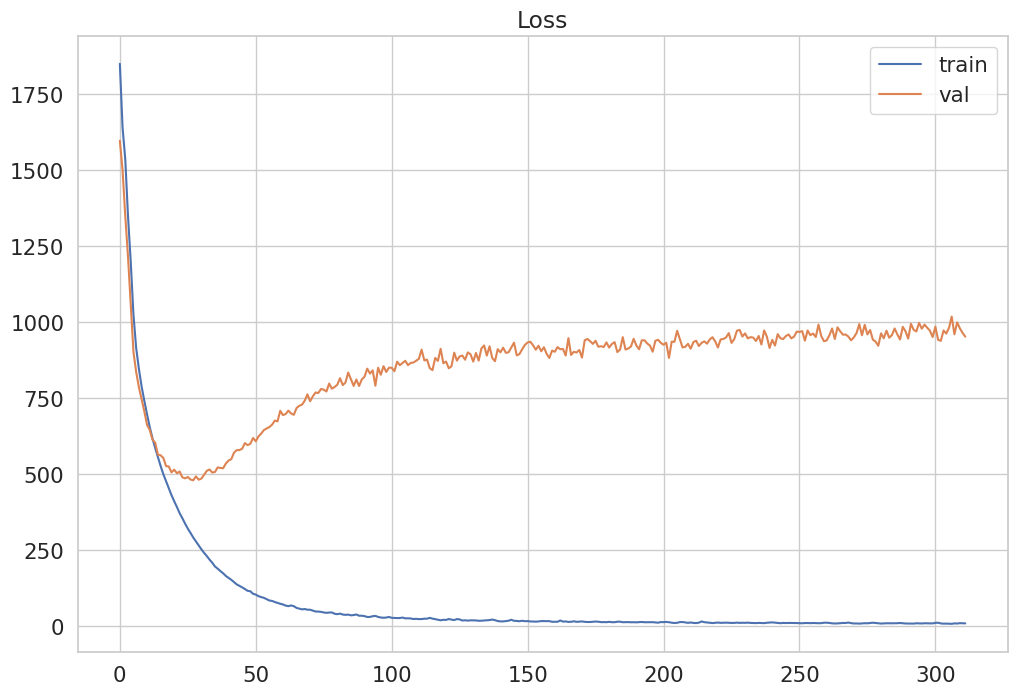

In [20]:
sns.set(style="whitegrid", font_scale=1.4)
plt.figure(figsize=(12, 8))
plt.plot(losses['Train'], label="train")
plt.plot(losses['Val'], label="val")
plt.title('Loss')
plt.legend()
plt.show()

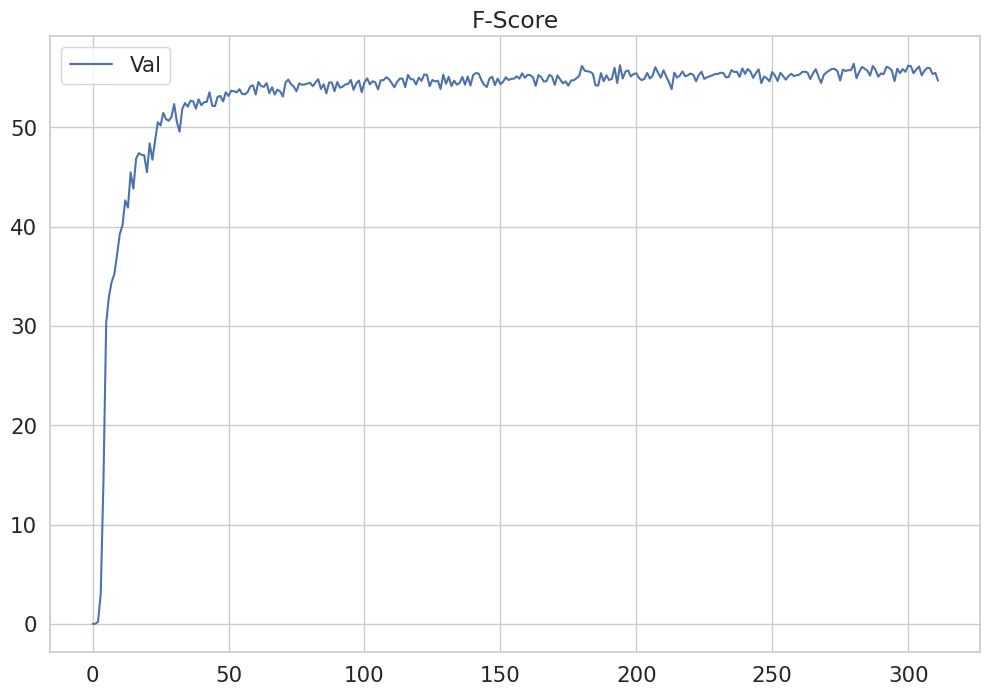

In [21]:
sns.set(style="whitegrid", font_scale=1.4)
plt.figure(figsize=(12, 8))
plt.plot(val_metrics['F_score'], label="Val")
plt.title('F-Score')
plt.legend()
plt.show()